![charm_logo](https://charmtx.com/wp-content/uploads/2022/05/CHARM_Logo_Colour.png)

## Take home coding challenge
### Role: Computational Chemist

Thank you for applying to CHARMTx! Below is a small take-home coding challenge.
__If you get stuck, please feel free to email us at finlay/beni/alwin@charmtx.com.__

**Task:** Given a protein (see attached PDB file) and a set of docked ligand poses (attached SDF file), could you please write a script that filters out ligand poses that do not contain a salt bridge between the ligand 5HT2A and the Aspartate at index 155 in the PDB file. The skeleton of the main function is provided. You are free to write as many helper functions as you wish. You may use any Python based chemoinformatic library (RDKit, OpenEye, OpenBabel). You will need a license for OpenEye if you choose to use it.


__Hints:__

- We define a salt bridge as an oxygen-nitrogen with a distance less than 3.5Å. You don't need to consider the protonation states. Conjugated nitrogens and nitrogens adjacent to aromatic systems should be discluded.


- In this task you will: 
    - load the protein and ligands
    - select atoms that could potentially form a salt bridge at D155
    - compute the distance between them
    - filter out ligand poses that do not form a salt bridge
    - saves the remiaining poses to an SDF file.
    
__Bonus points for:__

- Writing all functions with docstrings and specifying the types of the inputs and outputs.
- Adding an SDTag to the filtered ligands, indicating the distance of the salt bridge.

**Import libraries and presets**

In [ ]:
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole

from scipy.spatial.distance import cdist

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

**File Input**

In [2]:
def load_pdb(pdb_file: str) -> Chem.Mol:
    '''
    Loads a protein database file as an rdkit.Chem.Mol object.
    
    Inputs:
    -------
    - pdb_file: str
        Filepath for protein database file.
    
    Returns:
    --------
    - pdb: Chem.Mol
        A Chem.Mol representing the protein database file.
    '''
    pdb = Chem.MolFromPDBFile(pdb_file)
    
    residues = {atom.GetPDBResidueInfo().GetResidueNumber() for atom in pdb.GetAtoms()}
    
    print(f'Loaded PDB file with {len(residues)} residues and {Chem.rdMolDescriptors.CalcNumHeavyAtoms(pdb)} heavy atoms. \n') 
    
    return pdb
    
    
def load_sdf(sdf_file: str) -> list[Chem.Mol]:
    '''
    Loads a SDF file containing possible ligand positions as a list of rdkit.Chem.Mol objects.
    
    Inputs:
    -------
    - sdf_file: str
        Filepath for SDF file.
    
    Returns:
    --------
    - ligands: list[Chem.Mol]
        A list where each element is a different ligand position represented as a Chem.Mol object.
    '''
    suppl = Chem.SDMolSupplier(sdf_file)
    ligands = [ligand for ligand in suppl if ligand is not None]
    missing = [ligand for ligand in suppl if ligand is None]
    
    print(f'Loaded SDF file containing {len(suppl)} molecules,')
    print(f'{len(ligands)} read correctly, {len(missing)} read as None. \n')
    
    return ligands

In [3]:
pdb = load_pdb("protein_6a93.pdb")
all_ligands = load_sdf("ligands_5ht2a.sdf")

Loaded PDB file with 373 residues and 2932 heavy atoms. 

Loaded SDF file containing 414 molecules,
414 read correctly, 0 read as None. 



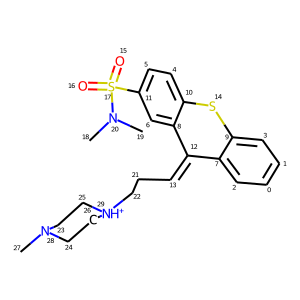

In [4]:
test_ligand = all_ligands[1]
test_ligand

**Finding coordinates of bridge forming Os in ASP**

In [22]:
def get_residue_atoms(protein: Chem.Mol, residue_index: int) -> list[int]:
    '''
    This function will return a list of all indexes of atoms belonging to a specified residue index in a given protein. The 
    protein must be imported from a PDB file otherwise GetPDBResidueInfo will return None.
    
    Inputs:
    -------
    - protein: Chem.Mol
        A Chem.Mol representing a PDB file.
    - residue_index: int
        The index of the desired residue in the protein.
    
    Returns:
    --------
    - residue_atoms_idxs: list[int]
        The indexes of all atoms in the chosen residue.
    '''

    assert protein.GetAtomWithIdx(0).GetPDBResidueInfo() != None, "No PDB residue information found."

    residue_atom_idxs = [atom.GetIdx() for atom in protein.GetAtoms() if atom.GetPDBResidueInfo().GetResidueNumber() == ResidueIndex]
    
    return residue_atom_idxs


def get_bridging_group(mol: Chem.Mol, residue_atoms_idxs: list[int], bridging_group_SMILE: str) -> list[int]:
    '''
    This function takes the SMILE string of a bridging group (e.g. COO- in ASP) and returns all indexes of atoms in that
    group from the list given (residue_atoms_idxs).
    
    Inputs:
    -------
    - mol: Chem.Mol
        The molecule that indexes in residue_atoms_idxs refer to.
    - residue_atoms_idxs: list[int]
        The indexes of chosen atoms in mol.
    - bridging_group_SMILE: str
        The SMILE string for the bridging group for this residue. 
    
    Returns:
    --------
    - bridging_group_idxs: list[int]
        The indexes of the bridging group atoms in this residue.
    '''
    bridging_group_idxs = []
    
    bridging_group = Chem.MolFromSmarts(bridging_group_SMILE)
    matches = mol.GetSubstructMatches(bridging_group)

    for match in matches:
        if set(match).issubset(set(residue_atom_idxs)):
            BridgingGroupIdxs.extend(match)
            
    return bridging_group_idxs
       

def filter_elements(mol: Chem.Mol, bridging_group_idxs: list[int], elements: set) -> list[int]:
    '''
    This function will return a subset of the ResidueAtomsIdxs list. All elements within the subset are indexes which 
    correspond to chemical elements in the elements set.
    
    Inputs:
    -------
    - mol: Chem.Mol
        The molecule that indexes in BridgingGroupIdxs refer to.
    - bridging_group_idxs: list[int]
        The indexes of chosen atoms in mol.
    - elements: set(str)
        A set of chemical elements that you wish to filter for e.g. set('N', 'S', 'Fe')
    
    Returns:
    --------
    - ResidueElementIdxs: list[int]
        A filtered subset of ResidueAtomsIdxs containing only atoms of specific element(s).
    '''
    residue_element_idxs = [idx for idx in bridging_group_idxs if mol.GetAtomWithIdx(idx).GetSymbol() in element]
    
    return residue_element_idxs


def get_positions(mol: Chem.Mol, residue_bridging_idxs: list[int]) -> np.ndarray:
    '''
    This function finds the xyz positions of each atom in mol whos index is given by residue_bridging_idxs.
    
    Inputs:
    -------
    - mol: Chem.Mol
        The molecule that indexes in residue_bridging_idxs refer to.
    - residue_bridging_idxs: list[int]
        The indexes of chosen atoms in mol.
    
    Returns:
    --------
    -coords: np.ndarray((n,3)) s.t. n = len(residue_bridging_idxs)
        The xyz position of each atom given in residue_bridging_idxs.
    '''
    coords = []
    
    for idx in residue_bridging_idxs:
    
        coord = [mol.GetConformer().GetAtomPosition(idx).x, 
                 mol.GetConformer().GetAtomPosition(idx).y, 
                 mol.GetConformer().GetAtomPosition(idx).z]

        coords.append((coord))
    
    return np.array(coords)


def positions_from_protein(protein: Chem.Mol, residue_index: int, elements: set) -> np.ndarray:
    '''
    This function gives the xyz coordinates of possible salt-bridging atoms in a specific protein residue. As long as these
    atoms are in beta positions to one another e.g. a carboxylate group (COO-).
    
    Inputs:
    -------
    - protein: Chem.Mol
        A Chem.Mol representing a PDB file.
    - residue_index: int
        The index of the desired residue in the protein.
    - elements: set(str)
        A set of chemical elements that you wish to filter for e.g. set('N', 'S', 'Fe')
        
    Returns:
    --------
    - _: np.ndarray((2,3))
        The xyz positions of salt-bridge forming carboxylate oxygen atoms (COO-) within a specific residue of a protein.
    '''
    residue_atom_idxs = get_residue_atoms(protein, residue_index)
    bridging_group_idxs = get_bridging_group(protein, residue_atom_idxs, 'C(=O)O')
    residue_element_idxs = filter_elements(protein, bridging_group_idxs, elements)
    atom_coords = get_positions(protein, residue_element_idxs)
    
    return atom_coords

In [23]:
## Testing 

residue_atom_idxs = get_residue_atoms(pdb, 155)
print(residue_atom_idxs)

bridging_group_idxs = get_bridging_group(pdb, residue_atom_idxs, 'C(=O)O')
print(bridging_group_idxs)

residue_element_idxs = filter_elements(pdb, bridging_group_idxs, set('O'))
print(residue_element_idxs)

O_positions = get_positions(pdb, residue_element_idxs)
print(O_positions)

ans = positions_from_protein(pdb, 155, set('O'))
print(ans)

[678, 679, 680, 681, 682, 683, 684, 685]
[683, 684, 685]
[684, 685]
[[16.103  3.516 61.899]
 [13.944  3.118 61.906]]
[[16.103  3.516 61.899]
 [13.944  3.118 61.906]]


**Excluding aromatic and aromatic adjacent atoms**

In [7]:
def discluded(ligand: Chem.Mol) -> set:
    '''
    This function finds indexes of all aromatic and aromatic adjactent atoms within a ligand. This is because aromatic and 
    aromatic adjacent atoms cannot form salt-bridges.
    
    In fact it is all conjugated atoms that cannot form salt-bridges as they contain too much electron density. However I
    am not sure how you would include any additional conjugated atoms in a general algorithm without over complicating it.
    
    Additionally this relies on rdkit's definition of aromatic (4n+2) rule. Worth checking that this is consistent with what
    you want.
    
    Inputs:
    -------
    - ligand: Chem.Mol
        The molecule that indexes in residue_bridging_idxs refer to.
    
    Returns:
    --------
    - discluded: set(int)
         set containing the indexes of all atoms in the ligand that are aromatic or aromatic adjacent.
    '''
    discluded = set()
    
    for i in range(Chem.rdMolDescriptors.CalcNumHeavyAtoms(ligand)):
        atom = ligand.GetAtomWithIdx(i)
        if atom.GetIsAromatic():
            discluded.add(i)
            
            neighbour = atom.GetNeighbors()
            neighbour = {neighbour[i].GetIdx() for i in range(len(neighbour))}
            discluded.update(neighbour)
            
    return discluded 

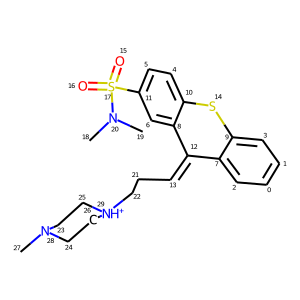

In [8]:
test_ligand

In [9]:
NN = discluded(test_ligand)
NN

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17}

**Distance Calculations**

In [21]:
def distance_between_atoms(protein_coords: np.ndarray, ligand_coords: np.ndarray) -> np.ndarray:
    '''
    Given an np.ndarray representing n atomic positions and another representing m, compute the distance between each 
    pair of positions between the two arrays. Will return an array of (n,m) shape. Uses SciPy library.

    Inputs:
    -------
    - protein_coords: np.ndarray((n,3))
        Coordinates of possible salt-bridge forming atoms in the protein.
    - ligand_coords: np.ndarray((m,3))
        Coordinates of possible salt-bridge forming atoms in the ligand.
    
    Returns:
    --------
    - distances: np.ndarray((n,m))
        The distances between each pair of positions between the two arrays.
    '''
    distances = cdist(protein_coords, ligand_coords, 'euclidean')
    
    return distances


def max_min_below_cutoff(distance_matrix: np.ndarray, cutoff_length: float) -> tuple:
    '''
    This function determines whether any of the potential salt-bridge distances that have been calcualted are beneath the 
    cutoff length. If one or more distance is below the cutoff then the maximum and minimum possible distances are returned,
    otherwise None is returned.
    
    Inputs:
    -------
    - distance_matrix: np.ndarray
        Array containing all of the possible salt-bridge distances.
    - cutoff_length: float
        The maximum possible length of a salt-bridge in Angstroms. 
    
    Returns:
    --------
    - max_min: tuple(float)
        If there is a suitable distance(s) then it is returned as a tuple of the maximum and minimum possible salt-bridge 
        length in Angstroms.
    - None:
        If all of the distances are above the cutoff the None is returned
    '''
    dist = distance_matrix.flatten()
    dist_sorted = -np.sort(-dist) # sorts in decsending order
    
    if dist_sorted.min() > cutoff_length:
        return None
    
    for i in range(len(dist_sorted)):
        if dist_sorted[i] <= cutoff_length:
            max_min = (dist_sorted[i], dist_sorted.min())
            return max_min

    raise ValueError(f'max_min_below_cutoff is causing an error for threshold length {threshold_length} and distances {dist_sorted}.')

In [11]:
## Testing ##
pos_a = np.array([[0,0,0], [1,1,1]])
pos_b = np.array([[1,0,0], [1,1,1]])

dist = DistanceBetweenAtoms(pos_a, pos_b)
print(dist)

bond_len = MaxMinBelowCutoff(dist, 1.5)
print(bond_len)

[[1.         1.73205081]
 [1.41421356 0.        ]]
(1.4142135623730951, 0.0)


**File Output**

In [12]:
def write_sdf(ligand_list: list[Chem.Mol], filepath: str):
    '''
    Write a list of Chem.Mol objects to an SDF file.
    
    Inputs:
    -------
    - ligand_list: list[Chem.Mol]
        A list of Chem.Mol objects to be written to the SDF file.
    - filepath: str
        Filepath for the newly created SDF file.
        
    Returns:
    --------
    None
    '''
    with Chem.SDWriter(filepath) as output:
        for ligand in ligand_list:
            output.write(ligand)
    
    print(f'Saved output as {filepath} with {len(ligand_list)} molecules. \n')

**Final Function: Filter Molecules**

In [13]:
def filter_mols(
    pdb_file: str, 
    input_ligand_sdf: str, 
    output_file_sdf: str, 
    asp_index: int, 
    salt_bridge_distance_cutoff: float = 3.5
):
    '''
    Function to filter input ligands to only those poses that contain a salt bridge with 
    the conserved aspartate in the GPCR. Saves the filtered ligands to an SDF file.
    
    Inputs:
    -------
    - pdb_file: str
        The PDB file of the protein to analyse.
            
    - input_ligand_sdf: str
        The sdf file of the docked ligand poses to filter.
            
    - output_file: str
        The sdf file to write the filtered ligands to.
            
    - asp_index: int
        The residue index representing the conserved Aspartate. It is 155 for 5HT2A.
            
    - salt_bridge_distance_cutoff: float
        Docked poses will be kept only if they have a salt bridge less than this specified value in Angstroms.
            
    Returns:
    --------
    None
    '''
    
    # import files
    protein = load_pdb(pdb_file)
    all_ligands = load_sdf(input_ligand_sdf)
    
    # calcualte positions of Os in carboxylate on ASP
    O_positions = positions_from_protein(protein, 155, set('O'))
    
    print('Filtering ligands... \n')

    # loop through ligands to determine if each can for a bridge
    ligands_below_cutoff = []
    for ligand in all_ligands:
        
        # create set of possible bridge forming nitrogens and find their positions
        lst = [i for i in range( len(ligand.GetAtoms()) )]
        all_Ns = filter_elements(ligand, lst, set('N'))
        discluded_Ns = discluded(ligand)
        Ns = set(all_Ns) - discluded_Ns
        
        if len(Ns) == 0:
            continue
            
        N_positions = get_positions(ligand, list(Ns))
        
        # calculate distances between ends of the bridge (Ns and Os)
        distance_matrix = distance_between_atoms(O_positions, N_positions)
        max_min_length = max_min_below_cutoff(distance_matrix, salt_bridge_distance_cutoff)
        
        # append ligand if it forms a salt bridge below cutoff      
        if max_min_length is not None:
            ligand.SetProp('salt_bridge_distance', str(max_min_length))
            ligands_below_cutoff.append(ligand)

    # output ligands that can form a salt-bridge shorter than the cutoff
    write_sdf(ligands_below_cutoff, output_file_sdf)


In [14]:
## Testing ##
filter_mols("protein_6a93.pdb", "ligands_5ht2a.sdf", "output.sdf", 155)

Loaded PDB file with 373 residues and 2932 heavy atoms. 

Loaded SDF file containing 414 molecules,
414 read correctly, 0 read as None. 

Filtering ligands... 

Saved output as output.sdf with 176 molecules. 



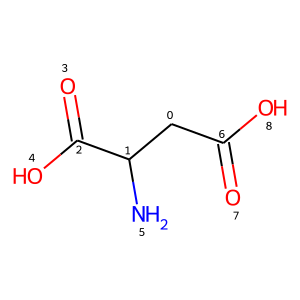

In [16]:
asp = Chem.MolFromSmiles('C(C(C(=O)O)N)C(=O)O')
asp